In [1]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random


import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts

from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time
import json
import xml.etree.ElementTree as ET


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%reload_ext autoreload

%autoreload 2

cpu


In [3]:
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane, d=metrics.distance):
    # k: desired number of nearest neighbours
    tree = MTree(d, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

def getMTreeFFT(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFTNumba(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft_numba, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

In [4]:
'''
SAVING TO DICTIONARY SORTING FILEPATHS BY CLASS
'''


imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/"
file_list = glob.glob(imgs_path + "*/")
# file_list = [glob.glob(annotation_path + "*.json")]
print(file_list)
# for file in file_list:
#     with open(file) as f:
#         annotations = json.load(f)
    
type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
        "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
        "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
categories = {}
for i in range(len(type_names)):
    categories[type_names[i]] = []



for file in file_list:
    for xml_file_path in glob.glob(file + "*.xml"):
        # print(xml_file_path)
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text
        img_path = file + img_path
        subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
        categories[subclass_type] = categories[subclass_type] + [img_path]

# for dir_path in file_list:
#     for cat in glob.glob(dir_path + "*"):
#         print(cat)
#         for xml_file_path in glob.glob(cat + "/*.xml"):
#             print(xml_file_path)
#             tree = ET.parse(xml_file_path)
#             root = tree.getroot()
#             img_path = root.find('filename').text
#             img_path = cat + "/" + img_path
#             # broad_class = root.find('object').find('class').text
#             # subclass = root.find('object').find('subclass').text
#             subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
#             # chip_data = [img_path, broad_class, subclass, subclass_type]
#             # adding chipdata to the dictionary entry w that class name
#             # self.categories[subclass_type] = self.categories[subclass_type] + chip_data
#             categories[subclass_type] = categories[subclass_type] + [img_path]
#         print(categories)
#             # self.data.append(chip_data)

    print(categories)

with open('/home/jovyan/data/EOC_azimuth_test_60_byclass.json', 'w', encoding='utf-8') as f:
    json.dump(categories, f, ensure_ascii=False, indent=4)




['/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Buick_Excelle_GT/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Buick_GL8/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/CNHTC_HOWO/', "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chang'an_CS75_Plus/", "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chang'an_Starlight_4500/", '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Changfeng_Cheetah_CFA6473C/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Changlin_8228-5/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chery_Arrizo 5/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chery_qq3/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Chevrolet_Blazer_1998/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Duolika/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_EQ6608LTV/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Forthing_Lingzhi/', '/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/Dongfeng_Tian

KeyboardInterrupt: 

In [5]:
def sort_by_class(imgs_path, file_list):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for dir_path in file_list:
        for cat in glob.glob(dir_path + "*"):
            for xml_file_path in glob.glob(cat + "/*.xml"):
                tree = ET.parse(xml_file_path)
                root = tree.getroot()
                img_path = root.find('filename').text
                img_path = cat + "/" + img_path
                subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
                categories[subclass_type] = categories[subclass_type] + [img_path]
                # self.data.append(chip_data)

        print(categories)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/" + imgs_path.split("/")[-2] + "_" + file_list[0].split("/")[-2] + "_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)

In [183]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_pol/"
file_list = [imgs_path + "test_HV/"]
sort_by_class(imgs_path, file_list)


{'Excelle_GT': ['/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_0_441082.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_110_348967.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_115_479385.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_120_282375.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_140_327068.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_145_560408.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_150_391545.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_170_230740.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_175_36730.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_180_190631.tif', '/home/jovyan/data/ATRNet-STAR/EOC_pol/test_HV/Buick_Excelle_GT/KU_HV_15_200_733413.tif

In [ ]:
'''
SPLITTING DATA INTO BUILD AND TEST
'''

def split_data(categories, p_left, p_right, filename):
    data = np.array([])
    test = np.array([])
    for key in categories:
        entry = np.array(categories[key])
        # print(entry)
        # print(type(entry))
        left_len = math.floor(p_left * len(entry))
        right_len = math.ceil(p_right * len(entry))
        sample_indices = np.array(random.sample(range(len(entry)), left_len))
        # print(sample_indices)
        # sampled_test_data = Subset(data, sample_indices)

        mask = np.ones(len(entry), np.bool)
        mask[sample_indices] = 0
        # These are all wrong omg ded
        left_partition = entry[sample_indices]
        right_partition = entry[mask]
        # print(type(left_partition))
        # print(left_partition)
        # print(right_partition)
        data = np.concatenate((data, left_partition))
        test = np.concatenate((test, right_partition), axis=0)
        # other_indices = np.arange(len(entry))[mask]
        # left_partition = Subset(entry, sample_indices)
        # right_partition = Subset(entry, )
        # other_data = data[mask]
    
    np.savez(filename, build=data, test=test)
    return filename

def split_one(categories):
    data = np.array([])
    test = np.array([])

    for key in categories:
        entry = np.array(categories[key])
        left_len = 1
        right_len = len(entry) - 1
        sample_indices = np.array(random.sample(range(len(entry)), left_len))

        mask = np.ones(len(entry), np.bool)
        mask[sample_indices] = 0
        # These are all wrong omg ded
        left_partition = entry[sample_indices]
        right_partition = entry[mask]
        # print(type(left_partition))
        # print(left_partition)
        # print(right_partition)
        data = np.concatenate((data, left_partition))
        test = np.concatenate((test, right_partition), axis=0)
        # other_indices = np.arange(len(entry))[mask]
        # left_partition = Subset(entry, sample_indices)
        # right_partition = Subset(entry, )
        # other_data = data[mask]

    np.savez("/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_1_rest_split.npz", build=data, test=test)
    return data, test

def save_list_data(image_size, split, annotations_path):

    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)


    testSample = [item[0] for item in data]
    print("Done w testSample")
    class_names = [item[1] for item in data]
    print("Done w class_names")
    subclass_names = [item[2] for item in data]
    print("Done w subclass_names")
    type_names = [item[3] for item in data]

    split_dict = {}
    split_dict["testSample"] = testSample
    split_dict["class_names"] = class_names
    split_dict["subclass_names"] = subclass_names
    split_dict["type_names"] = type_names

    filename = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_" + split.split("/")[-1]
    np.savez(filename, testSample=testSample, class_names=class_names, subclass_names=subclass_names, type_names=type_names)
    # with open("/home/jovyan/data/ATRNet-STAR_annotations/" + filename, 'w', encoding='utf-8') as f:
    #     json.dump(split_dict, f, ensure_ascii=False, indent=4)

def generate_split(image_size, categories, p_left, p_right, filename, annotations_path):
    split = split_data(categories, p_left, p_right, filename)
    save_list_data(image_size, split, annotations_path)


with open("/home/jovyan/data/ATRNet-STAR_annotations/EOC_azimuth_test_60_byclass.json") as f:
    categories = json.load(f)

annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"

generate_split(128, categories, 1, 0, "/home/jovyan/data/ATRNet-STAR_annotations/EOC_azimuth_test_60_100_0_split.npz", annotations_path)




# split_data(categories, 0.8, 0.2, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_80_20_split.npz")
# split_data(categories, 0.7, 0.3, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_70_30_split.npz")
# split_data(categories, 0.6, 0.4, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_60_40_split.npz")
# split_data(categories, 0.5, 0.5, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_50_50_split.npz")
# split_data(categories, 0.4, 0.6, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_40_60_split.npz")
# split_data(categories, 0.3, 0.7, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_30_70_split.npz")
# split_data(categories, 0.2, 0.8, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_20_80_split.npz")
# split_data(categories, 0.1, 0.9, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_10_90_split.npz")
# split_data(categories, 0.05, 0.95, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_05_95_split.npz")
# split_data(categories, 0.9, 0.1, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_90_10_split.npz")
# split_data(categories, 1, 0, "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_100_0_split.npz")
# split_one(categories)



NameError: name 'get_data_ATRNetSTARSplit' is not defined

In [151]:
'''
SAVING TO DICTIONARY FILE INFO W FILE NAME AS KEYS
'''

imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/"
# file_list = glob.glob(imgs_path + "*/")
file_list = [imgs_path + "test_60/"]
# file_list = [glob.glob(annotation_path + "*.json")]
print(file_list)    
annotations = {}



for dir_path in file_list:
    for cat in glob.glob(dir_path + "*"):
        #print(cat)
        for xml_file_path in glob.glob(cat + "/*.xml"):
            #print(xml_file_path)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            img_path = root.find('filename').text

            obj = root.find('object')
            broad_class = obj.find('class').text
            subclass = obj.find('subclass').text
            subclass_type = "_".join(obj.find('type').text.split("_")[1:])
            # chip_data = [img_path, broad_class, subclass, subclass_type]
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            x_len = int(obj.find('xmax').text) - xmin
            y_len = int(obj.find('ymax').text) - ymin
            bbox = [int(xmin), int(ymin), x_len, y_len]

            scene_name = root.find('scene').find('scene_name').text
            
            sensor = root.find('sensor')
            platform = sensor.find('platform').text
            strimap = sensor.find('imaging_mode').text
            band = sensor.find('band').text
            polarization = sensor.find('polarization').text
            range_resolution = sensor.find('range_resolution').text[:-1]
            cross_range_resolution = sensor.find('cross_range_resolution').text[:-1]
            depression_angle = sensor.find('depression_angle').text[:-1]
            target_azimuth_angle = sensor.find('target_azimuth_angle').text[:-1]

            annotations[img_path] = {
                "class": broad_class,
                "subclass": subclass,
                "type": subclass_type,
                "bbox": bbox,
                "scene_name": scene_name,
                "platform": platform,
                "strimap": strimap,
                "band": band,
                "polarization": polarization,
                "range_resolution": range_resolution,
                "cross_range_resolution": cross_range_resolution,
                "depression_angle": depression_angle,
                "target_azimuth_angle": target_azimuth_angle
            }


# with open('/home/jovyan/data/ATRNet-STAR_annotations.json', 'w', encoding='utf-8') as f:
#     json.dump(annotations, f, ensure_ascii=False, indent=4)

with open('/home/jovyan/data/EOC_azimuth_test_60_annotations.json', 'w', encoding='utf-8') as f:
    json.dump(annotations, f, ensure_ascii=False, indent=4)


['/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test_60/']


In [7]:
# AHHHHHH
def save_as_dict_keys_all(imgs_path):
    #imgs_path = "/home/jovyan/data/ATRNet-STAR/EOC_azimuth/"
    #file_list = [imgs_path + "test_60/"]
    # file_list = [glob.glob(annotation_path + "*.json")]
    #print(file_list)    
    annotations = {}
    for xml_file_path in glob.glob(imgs_path + "/*.xml"):
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text

        obj = root.find('object')
        broad_class = obj.find('class').text
        subclass = obj.find('subclass').text
        subclass_type = "_".join(obj.find('type').text.split("_")[1:])

        xmin = int(obj.find('xmin').text)
        ymin = int(obj.find('ymin').text)
        x_len = int(obj.find('xmax').text) - xmin
        y_len = int(obj.find('ymax').text) - ymin
        bbox = [int(xmin), int(ymin), x_len, y_len]

        scene_name = root.find('scene').find('scene_name').text
        
        sensor = root.find('sensor')
        platform = sensor.find('platform').text
        strimap = sensor.find('imaging_mode').text
        band = sensor.find('band').text
        polarization = sensor.find('polarization').text
        range_resolution = sensor.find('range_resolution').text[:-1]
        cross_range_resolution = sensor.find('cross_range_resolution').text[:-1]
        depression_angle = sensor.find('depression_angle').text[:-1]
        target_azimuth_angle = sensor.find('target_azimuth_angle').text[:-1]

        annotations[img_path] = {
            "class": broad_class,
            "subclass": subclass,
            "type": subclass_type,
            "bbox": bbox,
            "scene_name": scene_name,
            "platform": platform,
            "strimap": strimap,
            "band": band,
            "polarization": polarization,
            "range_resolution": range_resolution,
            "cross_range_resolution": cross_range_resolution,
            "depression_angle": depression_angle,
            "target_azimuth_angle": target_azimuth_angle
        }


    # with open('/home/jovyan/data/ATRNet-STAR_annotations.json', 'w', encoding='utf-8') as f:
    #     json.dump(annotations, f, ensure_ascii=False, indent=4)
    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/all_annotations.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(annotations, f, ensure_ascii=False, indent=4)


def sort_by_class_all(imgs_path):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for xml_file_path in glob.glob(imgs_path + "/*.xml"):
        print(xml_file_path)
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        img_path = root.find('filename').text
        img_path = imgs_path + img_path
        subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
        categories[subclass_type] = categories[subclass_type] + [img_path]
        # self.data.append(chip_data)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/all_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)


def get_new_dict_data_all(imgs_path):
    save_as_dict_keys_all(imgs_path)
    sort_by_class_all(imgs_path)


In [218]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/all/"
# file_list = [imgs_path + "test_HV/"]
get_new_dict_data_all(imgs_path)

KeyboardInterrupt: 

In [ ]:
# INITIALISING NEW DATA

def get_new_dict_data(imgs_path, file_list):
    save_as_dict_keys(imgs_path, file_list)
    sort_by_class(imgs_path, file_list)

def generate_split(image_size, categories, p_left, p_right, filename, annotations_path):
    split = split_data(categories, p_left, p_right, filename)
    save_list_data(image_size, split, annotations_path)

In [ ]:
def sort_by_class(imgs_path, file_list):
    # file_list = glob.glob(imgs_path + "*/")
    # print(file_list)


    type_names = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]
    categories = {}
    for i in range(len(type_names)):
        categories[type_names[i]] = []

    for dir_path in file_list:
        for cat in glob.glob(dir_path + "*"):
            for xml_file_path in glob.glob(cat + "/*.xml"):
                tree = ET.parse(xml_file_path)
                root = tree.getroot()
                img_path = root.find('filename').text
                img_path = cat + "/" + img_path
                subclass_type = "_".join(root.find('object').find('type').text.split("_")[1:])
                categories[subclass_type] = categories[subclass_type] + [img_path]
                # self.data.append(chip_data)

        print(categories)

    file_path = "/home/jovyan/data/ATRNet-STAR_annotations/" + imgs_path.split("/")[-2] + "_" + file_list[0].split("/")[-2] + "_byclass.json"
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(categories, f, ensure_ascii=False, indent=4)

In [ ]:
imgs_path = "/home/jovyan/data/ATRNet-STAR/all/"

get_new_dict_data()

In [61]:
class CustomDatasetATRNetSTAR(Dataset):
    def __init__(self, filename, annotations_path, transform=None):
        self.data = np.load(filename)
        with open(annotations_path) as f:
            self.annotations = json.load(f)
        


    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()
    
    
def get_data_ATRNetSTAR(size, filename, annotations_path):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTAR(filename, annotations_path, transform)

In [86]:
class CustomDatasetATRNetSTARSplit(Dataset):
    def __init__(self, filename, annotations_path, transform=None):
        data = np.load(filename)
        self.build = data["build"]
        self.test = data["test"]
        self.transform = transform
        with open(annotations_path) as f:
            self.annotations = json.load(f)
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.build)
    
    def get_test_len(self):
        return len(self.test)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = str(self.build[index])
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        filename = data_path.split("/")[-1]
        broad_class = self.annotations[filename]["class"]
        subclass = self.annotations[filename]["subclass"]
        subclass_type = self.annotations[filename]["type"]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), broad_class, subclass, subclass_type
    
    def get_test(self, index):
        data_path = self.test[index]
        image = Image.open(data_path)
        image = transforms.functional.to_grayscale(image)
        filename = data_path.split("/")[-1]
        broad_class = self.annotations[filename]["class"]
        subclass = self.annotations[filename]["subclass"]
        subclass_type = self.annotations[filename]["type"]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), broad_class, subclass, subclass_type


def get_data_ATRNetSTARSplit(size, filename, annotations_path):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTARSplit(filename, annotations_path, transform)

(array([[-0.90588236, -0.8352941 , -0.7019608 , ..., -0.7019608 ,
        -0.372549  , -0.5686275 ],
       [-0.75686276, -0.8352941 , -0.8745098 , ..., -0.85882354,
        -0.85882354, -0.5686275 ],
       [-0.73333335, -0.94509804, -0.8352941 , ..., -0.4980392 ,
        -0.10588235, -0.58431375],
       ...,
       [-0.92941177, -0.8980392 , -0.96862745, ..., -0.79607844,
        -0.77254903, -0.75686276],
       [-0.8745098 , -0.90588236, -0.90588236, ..., -0.79607844,
        -0.8117647 , -0.9529412 ],
       [-0.8901961 , -0.90588236, -0.9529412 , ..., -0.7647059 ,
        -0.7647059 , -0.9529412 ]], shape=(128, 128), dtype=float32), 'Car', 'Medium_Car', 'Excelle_GT')


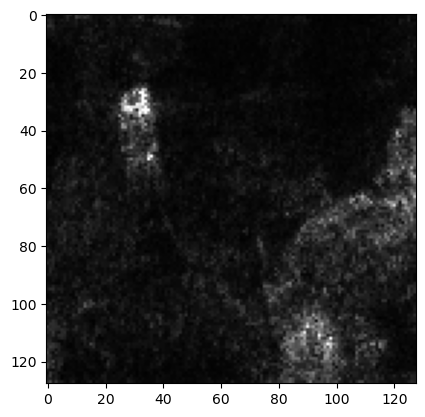

In [88]:
image_size = 128
filename = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_80_20_split.npz"
annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"
data = get_data_ATRNetSTARSplit(image_size, filename, annotations_path)

print(data[1])

plt.imshow(data.get_test(1)[0], cmap='grey')
plt.show()


In [191]:
def classification_accuracy(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    print(f"Classification accuracy based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")
    num_correct_types = 0
    num_correct_subclasses = 0
    num_correct_classes = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for i in range(runs):
        index1 = np.random.randint(data.get_test_len())
        
        unseen_image = data.get_test(index1)[0]
        unseen_class = data.get_test(index1)[1]
        unseen_subclass = data.get_test(index1)[2]
        unseen_type = data.get_test(index1)[3]

        # index1 = np.random.randint(len(data))
        # unseen_image = testSample[index1]
        # unseen_class = class_names[index1]
        # unseen_subclass = subclass_names[index1]
        # unseen_type = type_names[index1]

        # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")
        

        arr = np.ones(len(testSample))
        unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
        imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
        
        # put this in a function later
        class_dict = {}
        subclass_dict = {}
        type_dict = {}
        for index in imgProd_max_index:
            if (class_names[index] in class_dict):
                class_dict[class_names[index]] = class_dict[class_names[index]] + 1
            else:
                class_dict[class_names[index]] = 1
            if (subclass_names[index] in subclass_dict):
                subclass_dict[subclass_names[index]] = subclass_dict[subclass_names[index]] + 1
            else:
                subclass_dict[subclass_names[index]] = 1
            if (type_names[index] in type_dict):
                type_dict[type_names[index]] = type_dict[type_names[index]] + 1
            else:
                type_dict[type_names[index]] = 1
            
        
        predict_class = max(class_dict, key= lambda k: class_dict[k])
        predict_subclass = max(subclass_dict, key= lambda k: subclass_dict[k])
        predict_type = max(type_dict, key= lambda k: type_dict[k])
        # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

        if (predict_class == unseen_class):
            num_correct_classes += 1
        if (predict_subclass == unseen_subclass):
            num_correct_subclasses += 1
        if (predict_type == unseen_type):
            num_correct_types += 1

    print(f"Class accuracy: {num_correct_classes / runs}")
    print(f"Subclass accuracy: {num_correct_subclasses / runs}")
    print(f"Type accuracy: {num_correct_types / runs}")

In [209]:
def classification_accuracy_by_type(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    TYPES = ["Excelle_GT", "GL8", "CS75_Plus", "Starlight_4500", "Cheetah_CFA6473C", "8228-5", "Arrizo 5", "qq3", "Blazer_1998", "HOWO", "Duolika", "EQ6608LTV", "Forthing_Lingzhi",
            "Tianjin_DFH2200B", "Tianjin_KR230", "J6P", "Jiabao_T51", "BJ1045V9JB5-54", "Wall_poer", "Wall_Voleex_C50", "EV160B", "CA7180A3E", "h5", "N1", "HLF25_II", "Junling", "Patriot", 
            "SY5033XJH", "MKC", "Proud_2009", "V80", "Outlander_2003", "ZL40F", "DeLong_M3000", "DeLong_X3000", "Aochi_1800", "Aochi_Hongrui", "Rongguang_V", "YZK6590XCA", "ZK6120HY1"]

    print(f"Classification accuracy by type based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_types = 0
    num_correct_subclasses = 0
    num_correct_classes = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for type_name in TYPES:
        num_good_runs = 0
        num_correct_types = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_type = type_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_type = data.get_test(index1)[3]

            if (unseen_type == type_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                type_dict = {}
                for index in imgProd_max_index:
                    if (type_names[index] in type_dict):
                        type_dict[type_names[index]] = type_dict[type_names[index]] + 1
                    else:
                        type_dict[type_names[index]] = 1
                    
                
                predict_type = max(type_dict, key= lambda k: type_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_type == unseen_type):
                    num_correct_types += 1
        print(f"{type_name} classification accuracy: {num_correct_types / runs}")



def classification_accuracy_by_subclass(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    SUBCLASSES = ["Medium_Car", "Mini_Car", "Shovel_Loader", "Road_Roller", "ECV", "Ambulance", "Forklift", "Mixer_Truck", "Medium_TT", "Heavy_FT", "Light_PV", "Heavy_ST", "Heavy_DT", 
        "Light_DT", "Pickup", "Large_Bus", "Medium_Bus", "Small_Bus", "Medium_SUV", "Compact_SUV", "Large_Car"]

    print(f"Classification accuracy by subclass based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_subclasses = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for subclass_name in SUBCLASSES:
        num_good_runs = 0
        num_correct_subclasses = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_subclass = subclass_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_subclass = data.get_test(index1)[2]

            if (unseen_subclass == subclass_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                subclass_dict = {}
                for index in imgProd_max_index:
                    if (subclass_names[index] in subclass_dict):
                        subclass_dict[subclass_names[index]] = subclass_dict[subclass_names[index]] + 1
                    else:
                        subclass_dict[subclass_names[index]] = 1
                    
                predict_subclass = max(subclass_dict, key= lambda k: subclass_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_subclass == unseen_subclass):
                    num_correct_subclasses += 1
        print(f"{subclass_name} classification accuracy: {num_correct_subclasses / runs}")

def classification_accuracy_by_class(image_size=32, k=7, runs=100, split="filename", annotations_path="path", list_data="path"):
    
    data = get_data_ATRNetSTARSplit(image_size, split, annotations_path)

    CLASSES = ["Car", "Truck", "Bus", "Special"]

    print(f"Classification accuracy by class based on kNN with ncc with image size {image_size}, {k} neighbours, with split {split.split("/")[-1]} over {runs} runs")

    num_correct_subclasses = 0

    build = np.load(list_data)
    testSample = build["testSample"]
    print("Done w testSample")
    class_names = build["class_names"]
    print("Done w class_names")
    subclass_names = build["subclass_names"]
    print("Done w subclass_names")
    type_names = build["type_names"]
    print("Done w type_names")
    
    for class_name in CLASSES:
        num_good_runs = 0
        num_correct_classes = 0
        while (num_good_runs <= runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]
            unseen_class = class_names[index1]

            # print(f"Unseen image: {unseen_class} {unseen_subclass} {unseen_type}")

            # index1 = np.random.randint(data.get_test_len())
            # unseen_image = data.get_test(index1)[0]
            # unseen_class = data.get_test(index1)[1]

            if (unseen_class == class_name):
                num_good_runs += 1

                arr = np.ones(len(testSample))
                unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
                imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
                
                # put this in a function later
                class_dict = {}
                for index in imgProd_max_index:
                    if (class_names[index] in class_dict):
                        class_dict[class_names[index]] = class_dict[class_names[index]] + 1
                    else:
                        class_dict[class_names[index]] = 1
                    
                predict_class = max(class_dict, key= lambda k: class_dict[k])
                # print(f"Predicted class: {predict_class} subclass {predict_subclass} type {predict_type}")

                if (predict_class == unseen_class):
                    num_correct_classes += 1
        print(f"{class_name} classification accuracy: {num_correct_classes / runs}")

In [210]:
# Do this w everyth with 80/20...

split = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_100_0_split.npz"
annotations_path = "/home/jovyan/data/ATRNet-STAR_annotations/SOC_40classes_annotations.json"
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_SOC_40classes_100_0_split.npz"

classification_accuracy_by_class(image_size=128, k=5, runs=30, split=split, annotations_path=annotations_path, list_data=list_data)

Classification accuracy by class based on kNN with ncc with image size 128, 5 neighbours, with split SOC_40classes_100_0_split.npz over 30 runs
Done w testSample
Done w class_names
Done w subclass_names
Done w type_names
Car classification accuracy: 0.9
Truck classification accuracy: 0.8666666666666667
Bus classification accuracy: 0.8


KeyboardInterrupt: 

In [ ]:
def mtree_ncc_query_times_sample_size(image_size=128, k=7, runs=100, max_node_size=12, list_data="path", sample_sizes = []):

    print(f"Query times of diff methods based on kNN with ncc with image size {image_size}, {k} neighbours, mtree max node size {max_node_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

            
    avgs_ncc_pfft = []
    avgs_ncc_fft = []
    avgs_ncc_unoptim = []
    avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(sample_sizes)):
        
        time_ncc_pfft = 0
        time_ncc_fft = 0
        time_ncc_unoptim = 0
        time_mtree = 0
        time_mtree_fft = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        testSample = data[sample_indices]
        print("done with testSample")
        # tree = getMTree(testSample, max_node_size)
        tree_fft = getMTreeFFTNumba(testSample, max_node_size)
        

        print(f"Now testing with sample size: {sample_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]

            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_psearch(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_pfft += end_time - start_time
            
            start_time = time.perf_counter()
            arr = np.ones(len(testSample))
            unseen_img_arr = ImageProducts.linear_ncc_search(testSample, unseen_image, arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):][1:]
            end_time = time.perf_counter()
            time_ncc_fft += end_time - start_time

            # start_time = time.perf_counter()
            # arr = []
            # for j in range(len(testSample)):
            #     result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            #     arr.append(result)
            
            # unseen_img_arr = np.array(arr)
            # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            # time_ncc_unoptim += end_time - start_time

            # start_time = time.perf_counter()
            # knn = getKNearestNeighbours(tree, unseen_image, k)
            # end_time = time.perf_counter()
            # time_mtree += end_time - start_time

            start_time = time.perf_counter()
            knn = getKNearestNeighbours(tree_fft, unseen_image, k)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
        
        avg_ncc_pfft = time_ncc_pfft / runs
        avgs_ncc_pfft.append(avg_ncc_pfft)
        print(f"Avg time for ncc pfft: {avg_ncc_pfft}")

        avg_ncc_fft = time_ncc_fft / runs
        avgs_ncc_fft.append(avg_ncc_fft)
        print(f"Avg time for ncc fft: {avg_ncc_fft}")

        # avg_ncc_unoptim = time_ncc_unoptim / runs
        # avgs_ncc_unoptim.append(avg_ncc_unoptim)
        # print(f"Avg time for ncc unoptim: {avg_ncc_unoptim}")

        # avg_mtree = time_mtree / runs
        # avgs_mtree.append(avg_mtree)
        # print(f"Avg time for mtree: {avg_mtree}")

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_ncc_pfft)
    print(avgs_ncc_fft)
    # print(avgs_ncc_unoptim)
    # print(avgs_mtree)
    print(avgs_mtree_fft)
    # with open("/home/jovyan/evaluation/results/test_query_sample_sizes.txt", "w") as file:
    #     file.write(f"sample_sizes = {sample_sizes}")
    #     file.write(f"avgs_ncc_pfft = {avgs_ncc_pfft}")
    #     file.write(f"avgs_ncc_fft = {avgs_ncc_fft}")
    #     file.write(f"avgs_ncc_unoptim = {avgs_ncc_unoptim}")
    #     file.write(f"avgs_mtree = {avgs_mtree}")
    #     file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")
        

def mtree_query_times_max_node_size(image_size=128, k=7, runs=100, max_node_sizes=[], list_data="path", sample_size = 1000):

    print(f"Query times of mtree w {image_size}, {k} neighbours, variable mtree max node size, sample size {sample_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(max_node_sizes)):
    
        time_mtree_fft = 0
        
        sample_indices = random.sample(range(len(data)), sample_size)
        testSample = data[sample_indices]
        print("done with testSample")
        tree_fft = getMTreeFFTNumba(testSample, max_node_sizes[i])
        

        print(f"Now testing with max nod size: {max_node_sizes[i]}")
        for j in range(runs):

            index1 = np.random.randint(len(data))
            unseen_image = testSample[index1]

            start_time = time.perf_counter()
            knn = getKNearestNeighbours(tree_fft, unseen_image, k)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_mtree_fft)
    # with open("/home/jovyan/evaluation/results/test_query_max_nod_sizes.txt", "w") as file:
    #     file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")


def mtree_init_times_max_node_size(image_size=128, k=7, runs=100, max_node_sizes=[], list_data="path", sample_size = 1000):

    print(f"Init times of mtree w {image_size}, {k} neighbours, variable mtree max node size, sample size {sample_size} over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(max_node_sizes)):
    
        time_mtree_fft = 0
        
        print(f"Now testing with max node size: {max_node_sizes[i]}")
        for j in range(runs):
            sample_indices = random.sample(range(len(data)), sample_size)
            testSample = data[sample_indices]

            start_time = time.perf_counter()
            tree_fft = getMTreeFFTNumba(testSample, max_node_sizes[i])
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    print(avgs_mtree_fft)
    # with open("/home/jovyan/evaluation/results/test_init_max_nod_sizes.txt", "w") as file:
    #     file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")


def mtree_init_times_sample_sizes(image_size=128, k=7, runs=100, max_node_size=12, list_data="path", sample_sizes = []):

    print(f"Init times of mtree w {image_size}, {k} neighbours, max_node_size {max_node_size}, variable sample size over {runs} runs")

    data_list = np.load(list_data)
    data = data_list["testSample"]

    # avgs_mtree = []
    avgs_mtree_fft = []

    for i in range(len(sample_sizes)):
    
        # time_mtree = 0
        time_mtree_fft = 0
        
        print(f"Now testing with sample size: {sample_sizes[i]}")
        for j in range(runs):
            sample_indices = random.sample(range(len(data)), sample_sizes[i])
            testSample = data[sample_indices]

            # start_time = time.perf_counter()
            # tree = getMTree(testSample, max_node_size)
            # end_time = time.perf_counter()
            # time_mtree += end_time - start_time

            start_time = time.perf_counter()
            tree_fft = getMTreeFFTNumba(testSample, max_node_size)
            end_time = time.perf_counter()
            time_mtree_fft += end_time - start_time
    
        # avg_mtree = time_mtree / runs
        # avgs_mtree.append(avg_mtree)
        # print(f"Avg time for mtree: {avgs_mtree}")

        avg_mtree_fft = time_mtree_fft / runs
        avgs_mtree_fft.append(avg_mtree_fft)
        print(f"Avg time for mtree fft: {avg_mtree_fft}")

    # print(avgs_mtree)
    print(avgs_mtree_fft)
    # with open("/home/jovyan/evaluation/results/test_init_max_nod_sizes.txt", "w") as file:
    #     file.write(f"avgs_mtree = {avgs_mtree}"))
    #     file.write(f"avgs_mtree_fft = {avgs_mtree_fft}")

In [ ]:
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"

# print(np.load(list_data)["testSample"].shape)

mtree_ncc_query_times_sample_size(image_size=128, k=7, runs=3, max_node_size=12, list_data=list_data, sample_sizes = [100])


Query times of diff methods based on kNN with ncc with image size 128, 7 neighbours, mtree max node size 12 over 3 runs
